<a href="https://colab.research.google.com/github/mrbenbot/wimblepong/blob/main/Wimblepong_Reinforcement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Setup Google Colab Environment

# Install necessary packages
!pip install gym
# !pip install gym==0.21.0

!pip install stable-baselines3[extra]
!apt-get install -y xvfb python-opengl ffmpeg
!pip install imageio pillow
!pip install tensorflowjs




  Using cached stable_baselines3-2.3.2-py3-none-any.whl (182 kB)
  Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Using cached Shimmy-1.3.0-py3-none-any.whl (37 kB)
  Using cached AutoROM-0.6.1-py3-none-any.whl (9.4 kB)
  Using cached AutoROM.accept-rom-license-0.6.1.tar.gz (434 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (

In [ ]:
# Import necessary libraries
from gymnasium import spaces
import gymnasium as gym

import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from IPython import display

import os
import imageio
import glob
import math

from IPython.display import display, Image, HTML

import tensorflow as tf
from tensorflow.keras import layers
import torch as th
import numpy as np


# Check versions
print("gym version:", gym.__version__)
print("stable-baselines3 version:", stable_baselines3.__version__)


gym version: 0.29.1
stable-baselines3 version: 2.3.2


In [ ]:
rewards_map = {
    "hit_paddle": lambda rally_length: min(rally_length, 3),
    "score_point": lambda _: 5,
    "conceed_point": lambda rallyLength: min(-0.1, -2 + min(rallyLength / 5, 1)),
    "serve": lambda ball_speed: ball_speed / 10
}

In [ ]:

# Define constants based on your game's settings
COURT_HEIGHT = 800
COURT_WIDTH = 1200
PADDLE_HEIGHT = 90
PADDLE_WIDTH = 15
BALL_RADIUS = 12
INITIAL_BALL_SPEED = 10
PADDLE_SPEED_DIVISOR = 15  # Example value, adjust as needed
PADDLE_CONTACT_SPEED_BOOST_DIVISOR = 4  # Example value, adjust as needed
SPEED_INCREMENT = 0.6  # Example value, adjust as needed
SERVING_HEIGHT_MULTIPLIER = 2  # Example value, adjust as needed
PLAYER_COLOURS = {'Player1': 'blue', 'Player2': 'red'}
MAX_COMPUTER_PADDLE_SPEED = 10

class Player:
    Player1 = 'Player1'
    Player2 = 'Player2'

class PlayerPositions:
    Initial = 'Initial'
    Reversed = 'Reversed'

class GameEventType:
    ResetBall = 'ResetBall'
    Serve = 'Serve'
    WallContact = 'WallContact'
    HitPaddle = 'HitPaddle'
    ScorePointLeft = 'ScorePointLeft'
    ScorePointRight = 'ScorePointRight'

def get_bounce_angle(paddle_y, paddle_height, ball_y):
    relative_intersect_y = (paddle_y + (paddle_height / 2)) - ball_y
    normalized_relative_intersect_y = relative_intersect_y / (paddle_height / 2)
    return normalized_relative_intersect_y * ( math.pi / 4)

class CustomPongEnv(gym.Env):
    def __init__(self):
        super(CustomPongEnv, self).__init__()

        # Define action space: [buttonPressed, paddleDirection]
        self.action_space = spaces.Box(low=np.array([0, -60]), high=np.array([1, 60]), dtype=np.float32)


        # Observations: Ball and paddle positions and velocities, serve and score mode flags, and rally length
        self.observation_space = spaces.Box(
            low=np.array([0, 0, -np.inf, -np.inf, 0, 0, 0, 0, 0], dtype=np.float32),
            high=np.array([COURT_WIDTH, COURT_HEIGHT, np.inf, np.inf, COURT_HEIGHT, COURT_HEIGHT, 1, 1, 1], dtype=np.float32)
        )

        # Define the possible star

        # Define the possible starting states
        self.starting_states = [
           {'server': Player.Player1, 'positions_reversed': False, 'computer': Player.Player2},
           {'server': Player.Player1, 'positions_reversed': True, 'computer': Player.Player2},
           {'server': Player.Player2, 'positions_reversed': False, 'computer': Player.Player2},
           {'server': Player.Player2, 'positions_reversed': True, 'computer': Player.Player2},
           {'server': Player.Player2, 'positions_reversed': False, 'computer': Player.Player1},
           {'server': Player.Player2, 'positions_reversed': True, 'computer': Player.Player1},
           {'server': Player.Player1, 'positions_reversed': False, 'computer': Player.Player1},
           {'server': Player.Player1, 'positions_reversed': True, 'computer': Player.Player1},
        ]


        self.serve_delay = 50
        self.serve_delay_counter = 0
        self.direction = 15
        self.is_done = False
        self.frame_count = 0

        self.last_event = None

        # Initialize the game state
        self.reset(seed=0)

    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]

    def reset(self, seed=None):
        super().reset(seed=seed)
        if seed is not None:
            self.seed(seed)
        # Select a random starting state
        starting_state = np.random.choice(self.starting_states)

        # Set the server, positions, and computer player based on the starting state
        server = starting_state['server']
        positions_reversed = starting_state['positions_reversed']
        computer = starting_state['computer']

        # Initialize the game state
        self.state = {
            'server': server,
            'positionsReversed': positions_reversed,
            'computer': computer,
            'paddle1': {'x': 0, 'y': COURT_HEIGHT // 2 - PADDLE_HEIGHT // 2, 'dy': 0, 'width': PADDLE_WIDTH, 'height': PADDLE_HEIGHT, 'colour': 'blue'},
            'paddle2': {'x': COURT_WIDTH - PADDLE_WIDTH, 'y': COURT_HEIGHT // 2 - PADDLE_HEIGHT // 2, 'dy': 0, 'width': PADDLE_WIDTH, 'height': PADDLE_HEIGHT, 'colour': 'red'},
            'ball': {'x': COURT_WIDTH // 2, 'y': COURT_HEIGHT // 2, 'dx': INITIAL_BALL_SPEED, 'dy': INITIAL_BALL_SPEED, 'radius': BALL_RADIUS, 'speed': INITIAL_BALL_SPEED, 'serveMode': True, 'scoreMode': False, 'scoreModeTimeout': 0},
            'stats': {'rallyLength': 0, 'serveSpeed': INITIAL_BALL_SPEED, 'server': server}
        }
        self.is_done = False

        # Apply the meta game state adjustments
        self.apply_meta_game_state(self.state, server, PlayerPositions.Reversed if positions_reversed else PlayerPositions.Initial)

        # Extract necessary game state variables
        ball = self.state['ball']
        stats = self.state['stats']
        paddle1 = self.state['paddle1']
        paddle2 = self.state['paddle2']
        positions_reversed = self.state['positionsReversed']
        server = self.state['server']

        # Apply provided logic
        left = (server == Player.Player1 and not positions_reversed) or (server == Player.Player2 and positions_reversed)
        ball['y'] = paddle1['height'] / 2 + paddle1['y'] if left else paddle2['height'] / 2 + paddle2['y']
        ball['x'] = paddle1['width'] + ball['radius'] if left else COURT_WIDTH - paddle2['width'] - ball['radius']
        ball['speed'] = INITIAL_BALL_SPEED
        ball['serveMode'] = True
        ball['scoreMode'] = False
        ball['scoreModeTimeout'] = 0
        stats['rallyLength'] = 0

        # Initialize frame count and ensure frames directory exists
        # self.frame_count = 0
        if not os.path.exists('frames'):
            os.makedirs('frames')
        return self._get_obs(), {}

    def apply_meta_game_state(self, game_state, serving_player, player_positions):
        positions_reversed = player_positions == PlayerPositions.Reversed

        game_state['server'] = serving_player
        game_state['positionsReversed'] = positions_reversed

        # Set paddle heights
        if ((serving_player == Player.Player1 and not positions_reversed) or
                (serving_player == Player.Player2 and positions_reversed)):
            game_state['paddle1']['height'] = PADDLE_HEIGHT * SERVING_HEIGHT_MULTIPLIER
            game_state['paddle2']['height'] = PADDLE_HEIGHT
        else:
            game_state['paddle1']['height'] = PADDLE_HEIGHT
            game_state['paddle2']['height'] = PADDLE_HEIGHT * SERVING_HEIGHT_MULTIPLIER

        # Set paddle colours
        if positions_reversed:
            game_state['paddle1']['colour'] = PLAYER_COLOURS[Player.Player2]
            game_state['paddle2']['colour'] = PLAYER_COLOURS[Player.Player1]
        else:
            game_state['paddle1']['colour'] = PLAYER_COLOURS[Player.Player1]
            game_state['paddle2']['colour'] = PLAYER_COLOURS[Player.Player2]

    def step(self, action):
        buttonPressed = bool(action[0] > 0.5)  # Convert continuous value to discrete
        paddleDirection = action[1]  # This remains as a continuous value

        computer_player_actions = self.get_computer_player_actions(self.state['computer'])
        model_player_actions = {'buttonPressed': buttonPressed, 'paddleDirection': paddleDirection}

        (left_player, right_player) = (Player.Player2, Player.Player1) if self.state['positionsReversed'] else (Player.Player1, Player.Player2)
        regular_positions = self.state['computer'] == left_player

        left_actions, right_actions = (computer_player_actions, model_player_actions) if regular_positions else (model_player_actions, computer_player_actions)

        prev_ball_x = self.state['ball']['x']
        reward = self.update_game_state(
            self.state, left_actions, right_actions,
            self.state['server'], self.state['positionsReversed'], 0.8, self.fire_event, left_player
        )

        obs = self._get_obs()
        # reward = self.calculate_reward(prev_ball_x, left_player)
        done = self.check_done()
        info = {}
        terminated = done
        truncated = False  # Add logic if you want to support truncation

        return obs, reward, terminated, truncated, info

    def update_game_state(self, game_state, left_player_actions, right_player_actions, serving_player, positions_reversed, delta_time, fire_event, left_player):
        reward = 0
        ball = game_state['ball']
        paddle1 = game_state['paddle1']
        paddle2 = game_state['paddle2']
        stats = game_state['stats']
        model_is_left = (left_player != self.state['computer'])

        if ball['scoreMode']:
            if ball['scoreModeTimeout'] < 50:
                ball['scoreModeTimeout'] += delta_time
            else:
                fire_event(GameEventType.ResetBall)
        elif ball['serveMode']:
            if (serving_player == Player.Player1 and not positions_reversed) or (serving_player == Player.Player2 and positions_reversed):
                ball['dy'] = (paddle1['y'] + paddle1['height'] / 2 - ball['y']) / PADDLE_SPEED_DIVISOR
                ball['x'] = paddle1['width'] + ball['radius']
                if left_player_actions['buttonPressed']:
                    ball['speed'] = INITIAL_BALL_SPEED
                    ball['dx'] = INITIAL_BALL_SPEED
                    ball['serveMode'] = False
                    fire_event(GameEventType.Serve)
                    if model_is_left:
                      reward += rewards_map['serve'](abs(ball['dy']) + abs(ball['dx']))
            else:
                ball['dy'] = (paddle2['y'] + paddle2['height'] / 2 - ball['y']) / PADDLE_SPEED_DIVISOR
                ball['x'] = COURT_WIDTH - paddle2['width'] - ball['radius']
                if right_player_actions['buttonPressed']:
                    ball['speed'] = INITIAL_BALL_SPEED
                    ball['dx'] = -INITIAL_BALL_SPEED
                    ball['serveMode'] = False
                    fire_event(GameEventType.Serve)
                    if not model_is_left:
                      reward += rewards_map['serve'](abs(ball['dy']) + abs(ball['dx']))
            ball['y'] += ball['dy'] * delta_time
        else:
            ball['x'] += ball['dx'] * delta_time
            ball['y'] += ball['dy'] * delta_time

            # Check for collisions with top and bottom walls
            if ball['y'] - ball['radius'] < 0:
                ball['dy'] = -ball['dy']
                ball['y'] = ball['radius']  # Adjust ball position to avoid sticking
                fire_event(GameEventType.WallContact)
            elif ball['y'] + ball['radius'] > COURT_HEIGHT:
                ball['dy'] = -ball['dy']
                ball['y'] = COURT_HEIGHT - ball['radius']  # Adjust ball position to avoid sticking
                fire_event(GameEventType.WallContact)

            # Update ball collision detection and response
            if ball['x'] - ball['radius'] < paddle1['x'] + paddle1['width'] and ball['y'] + ball['radius'] > paddle1['y'] and ball['y'] - ball['radius'] < paddle1['y'] + paddle1['height']:
                bounce_angle = get_bounce_angle(paddle1['y'], paddle1['height'], ball['y'])
                ball['dx'] = (ball['speed'] + abs(paddle1['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * math.cos(bounce_angle)
                ball['dy'] = (ball['speed'] + abs(paddle1['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * -math.sin(bounce_angle)
                ball['x'] = paddle1['x'] + paddle1['width'] + ball['radius']  # Adjust ball position to avoid sticking
                ball['speed'] += SPEED_INCREMENT
                stats['rallyLength'] += 1
                fire_event(GameEventType.HitPaddle)
                if model_is_left:
                  reward += rewards_map["hit_paddle"](stats['rallyLength'])
            elif ball['x'] + ball['radius'] > paddle2['x'] and ball['y'] + ball['radius'] > paddle2['y'] and ball['y'] - ball['radius'] < paddle2['y'] + paddle2['height']:
                bounce_angle = get_bounce_angle(paddle2['y'], paddle2['height'], ball['y'])
                ball['dx'] = -(ball['speed'] + abs(paddle2['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * math.cos(bounce_angle)
                ball['dy'] = (ball['speed'] + abs(paddle2['dy']) / PADDLE_CONTACT_SPEED_BOOST_DIVISOR) * -math.sin(bounce_angle)
                ball['x'] = paddle2['x'] - ball['radius']  # Adjust ball position to avoid sticking
                ball['speed'] += SPEED_INCREMENT
                stats['rallyLength'] += 1
                fire_event(GameEventType.HitPaddle)
                if not model_is_left:
                  reward += rewards_map["hit_paddle"](stats['rallyLength'])
            # Check for scoring
            if ball['x'] - ball['radius'] < 0:
                fire_event(GameEventType.ScorePointLeft)
                ball['scoreMode'] = True
                if model_is_left:
                  reward += rewards_map['conceed_point'](stats['rallyLength'])
                else:
                  reward += rewards_map['score_point']()
            elif ball['x'] + ball['radius'] > COURT_WIDTH:
                fire_event(GameEventType.ScorePointRight)
                ball['scoreMode'] = True
                if not model_is_left:
                  reward += rewards_map['conceed_point'](stats['rallyLength'])
                else:
                  reward += rewards_map['score_point']()

        paddle1['dy'] = -left_player_actions['paddleDirection']
        paddle1['y'] += paddle1['dy'] * delta_time

        paddle2['dy'] = right_player_actions['paddleDirection']
        paddle2['y'] += paddle2['dy'] * delta_time

        # Ensure paddles stay within screen bounds
        if paddle1['y'] < 0:
            paddle1['y'] = 0
        if paddle1['y'] + paddle1['height'] > COURT_HEIGHT:
            paddle1['y'] = COURT_HEIGHT - paddle1['height']

        if paddle2['y'] < 0:
            paddle2['y'] = 0
        if paddle2['y'] + paddle2['height'] > COURT_HEIGHT:
            paddle2['y'] = COURT_HEIGHT - paddle2['height']

        # Update stats during a serve
        if ball['serveMode'] and (left_player_actions['buttonPressed'] or right_player_actions['buttonPressed']):
            stats['rallyLength'] += 1
            stats['serveSpeed'] = abs(ball['dy']) + abs(ball['dx'])
            stats['server'] = serving_player

        reward += 0.01
        return reward

    def fire_event(self, event_type):
        if event_type == GameEventType.ScorePointLeft or event_type == GameEventType.ScorePointRight:
          self.is_done = True
        # Handle game events (e.g., reset ball position, serve, etc.)
        pass

    def get_computer_player_actions(self, player):
        state = self.state
        is_left = (player == Player.Player1 and not state['positionsReversed']) or (player == Player.Player2 and state['positionsReversed'])
        if state['ball']['scoreMode']:
            self.serve_delay_counter = 0
            self.direction = 30 * np.random.rand()
            self.serve_delay = 100 * np.random.rand()
            self.direction = self.direction if np.random.rand() > 0.5 else -self.direction
            return {'buttonPressed': False, 'paddleDirection': 0}

        if state['ball']['serveMode']:
            paddle = state['paddle2'] if is_left else state['paddle1']
            if paddle['y'] <= 0 or paddle['y'] + paddle['height'] >= COURT_HEIGHT:
                self.direction = -self.direction
            if self.serve_delay_counter > self.serve_delay:
                return {'buttonPressed': True, 'paddleDirection': self.direction}
            else:
                self.serve_delay_counter += 1
                return {'buttonPressed': False, 'paddleDirection': self.direction}


        if is_left:
          return {
              'buttonPressed': False,
              'paddleDirection': self.bounded_value(
                  state['paddle1']['y'] - state['ball']['y'] + state['paddle1']['height'] / 2,
                  -MAX_COMPUTER_PADDLE_SPEED,
                  MAX_COMPUTER_PADDLE_SPEED
              )
          }
        else:
          return {
              'buttonPressed': False,
              'paddleDirection': -self.bounded_value(
                  state['paddle2']['y'] - state['ball']['y'] + state['paddle2']['height'] / 2,
                  -MAX_COMPUTER_PADDLE_SPEED,
                  MAX_COMPUTER_PADDLE_SPEED
              )
          }

    def bounded_value(self, value, min_value, max_value):
        return max(min_value, min(max_value, value))

    def _get_obs(self):
        state = self.state
        player = Player.Player1 if self.state['computer'] == Player.Player2 else Player.Player2
        is_player1 = 1 if player == Player.Player2 else 0
        is_server = 1 if self.state['server'] == player else 0

        return np.array([
            float(state['ball']['x']),
            float(state['ball']['y']),
            float(state['ball']['dx']),
            float(state['ball']['dy']),
            float(state['paddle1']['y']),
            float(state['paddle2']['y']),
            float(int(state['ball']['serveMode'])),
            float(is_player1),
            float(is_server)
        ], dtype=np.float32)


    def check_done(self):
        # Determine if the episode is done
        if self.state['stats']['rallyLength'] > 100:
          return True
        return self.is_done

    def render(self, mode='human', close=False):
        if close:
            plt.close()
            return

        if not hasattr(self, 'fig'):
            self.fig, self.ax = plt.subplots()
            self.ax.set_xlim(0, COURT_WIDTH)
            self.ax.set_ylim(0, COURT_HEIGHT)
            self.ax.set_aspect('equal')
            plt.gca().invert_yaxis()  # Invert y-axis to match the coordinate system

        self.ax.clear()
        self.ax.set_xlim(0, COURT_WIDTH)
        self.ax.set_ylim(0, COURT_HEIGHT)

        # Draw paddles
        paddle1 = self.state['paddle1']
        paddle2 = self.state['paddle2']


        self.ax.add_patch(patches.Rectangle((paddle1['x'], paddle1['y']), paddle1['width'], paddle1['height'], color=paddle1['colour']))
        self.ax.add_patch(patches.Rectangle((paddle2['x'], paddle2['y']), paddle2['width'], paddle2['height'], color=paddle2['colour']))

        # Draw ball
        ball = self.state['ball']
        self.ax.add_patch(patches.Circle((ball['x'], ball['y']), ball['radius'], color='black'))

        # Capture the frame
        plt.draw()
        frame_path = f'frames/frame_{self.frame_count:04d}.png'
        self.fig.savefig(frame_path)
        self.frame_count += 1

    def close(self):
        if hasattr(self, 'fig'):
            plt.close(self.fig)

        # Check if frames directory exists
        if not os.path.exists('frames'):
            print("No frames directory found, skipping video creation.")
            return

        # Create GIF from frames
        with imageio.get_writer('pong_game.gif', mode='I', duration=0.017) as writer:
            for filename in sorted(glob.glob('frames/frame_*.png')):
                image = imageio.imread(filename)
                writer.append_data(image)

        # Display the GIF
        display(Image(filename='pong_game.gif'))

        # Remove frames
        for file in os.listdir('frames'):
            os.remove(os.path.join('frames', file))
        os.rmdir('frames')




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Initial observation: (array([1.173e+03, 4.450e+02, 1.000e+01, 1.000e+01, 3.550e+02, 3.550e+02,
       1.000e+00, 0.000e+00, 1.000e+00], dtype=float32), {})
Action taken: [0.9629618 9.511993 ]
Observation: [ 1.173000e+03  4.450000e+02 -1.000000e+01  0.000000e+00  3.430000e+02
  3.626096e+02  0.000000e+00  0.000000e+00  1.000000e+00]
Reward: 1.01
iteration: 0
Done: False
Action taken: [  0.47985917 -13.363714  ]
Observation: [ 1.165000e+03  4.450000e+02 -1.000000e+01  0.000000e+00  3.510000e+02
  3.519186e+02  0.000000e+00  0.000000e+00  1.000000e+00]
Reward: 0.01
iteration: 1
Done: False
Action taken: [0.6837731 7.5734453]
Observation: [ 1.157000e+03  4.450000e+02 -1.000000e+01  0.000000e+00  3.590000e+02
  3.579774e+02  0.000000e+00  0.000000e+00  1.000000e+00]
Reward: 0.01
iteration: 2
Done: False
Action taken: [  0.79650176 -14.278546  ]
Observation: [ 1.1490000e+03  4.4500000e+02 -1.0000000e+01  0.0000000e+00
  3.6700000e+02  3.4655453e+02  0.0000000e+00  0.0000000e+00
  1.0000000e+

<ipython-input-27-f5fbf5974782>:413: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


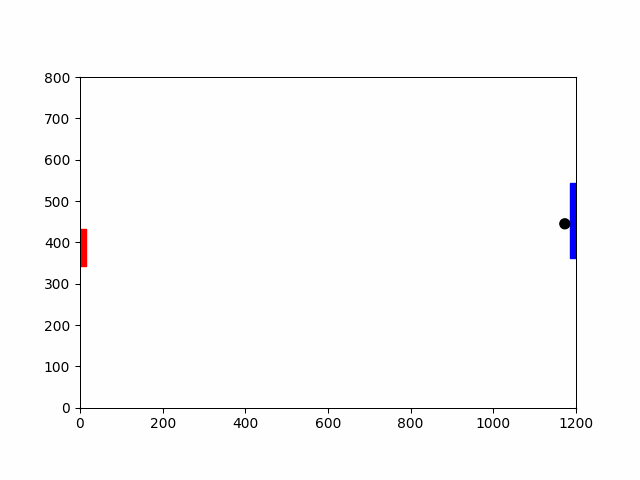

In [ ]:
# Test the custom environment
env = CustomPongEnv()
obs = env.reset()
print("Initial observation:", obs)

for i in range(1000):
    action = env.action_space.sample()  # Sample random action
    obs, reward, done, info, _ = env.step(action)
    print("Action taken:", action)
    print("Observation:", obs)
    print("Reward:", reward)
    print('iteration:', i)
    print("Done:", done)
    env.render()
    if done:
        break

env.close()

In [ ]:
# Initialize the custom environment
env = CustomPongEnv()

# Check the environment (optional, to ensure the environment follows Gym's API)
check_env(env, warn=True)

# Define the model
model = PPO("MlpPolicy", env, verbose=1)

# Define evaluation callback
eval_callback = EvalCallback(env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=1000,
                             deterministic=True, render=False)

# Train the model
model.learn(total_timesteps=500000, callback=eval_callback)

# Save the model
model.save("ppo_custom_pong")

# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

# To load the trained model
# model = PPO.load("ppo_custom_pong")


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/env_checker.py:453: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
|    loss                 | 0.0397      |
|    n_updates            | 1210        |
|    policy_gradient_loss | -0.00561    |
|    std                  | 0.693       |
|    value_loss           | 0.0243      |
-----------------------------------------
Eval num_timesteps=249000, episode_reward=4.14 +/- 0.00
Episode length: 473.60 +/- 0.49
---------------------------------
| eval/              |          |
|    mean_ep_length  | 474      |
|    mean_reward     | 4.14     |
| time/              |          |
|    total_timesteps | 249000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 721      |
|    ep_rew_mean     | 9.7      |
| time/              |          |
|    fps             | 359      |
|    iterations      | 122      |
|    time_elapsed    | 694      |
|    total_timesteps | 249856   |
---------------------------------
Eval num_timesteps=250000, epis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[1.        2.3416796]
[1.         0.67944366]
[1.        1.2114851]
[0.85493195 0.8201816 ]
[1.        1.1567897]
[1.        1.9085555]
[0.97330254 2.1744018 ]
[0.73632383 1.1455728 ]
[0.        1.4536284]
[0.74650896 1.7650367 ]
[0.89431095 1.056013  ]
[1.        1.5722339]
[0.9652331 1.8405639]
[0.60648644 1.6648766 ]
[1.        1.4917274]
[1.        1.4595971]
[0.7101649 0.4949541]
[0.6675061 1.0199803]
[1.         0.45635152]
[0.11617427 0.10922498]
[ 0.         -0.48024768]
[ 0.8829399 -0.9526529]
[ 0.        -1.2843168]
[ 0.       -1.331486]
[ 0.96900344 -0.8837584 ]
[ 0.13381785 -0.9637403 ]
[ 0.3961327 -0.7765626]
[ 1.        -1.4476423]
[ 0.05379641 -0.43374693]
[ 0.1156525 -1.2849681]
[ 0.438193  -1.3010314]
[ 0.47257757 -0.15986776]
[ 0.21835281 -0.9155643 ]
[ 0.64242154 -0.66730356]
[ 0.00708377 -0.98712915]
[ 0.        -1.6774908]
[ 0.7239341  -0.36952895]
[ 0.65376884 -1.3757093 ]
[ 0.        -1.0140932]
[ 0.27698112 -1.1535627 ]
[ 0.10158774 -0.9946264 ]
[ 0.4025678 -0.5

<ipython-input-32-09a21a547492>:413: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


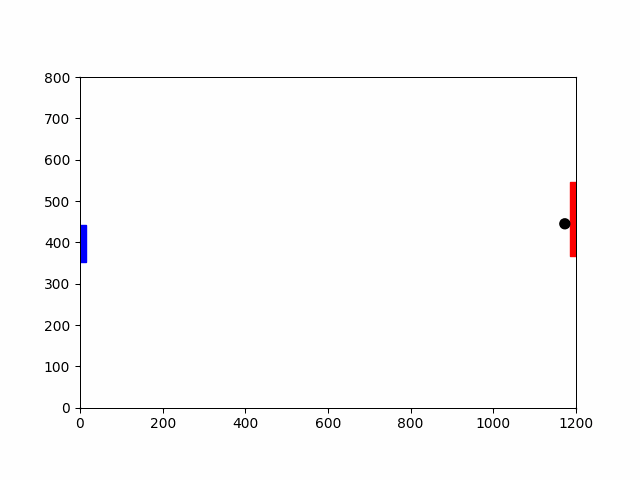

In [ ]:
env = CustomPongEnv()
model = PPO.load("ppo_custom_pong")

obs, _ = env.reset()
for _ in range(1000):
    action, _states = model.predict(obs)
    print(action)
    obs, rewards, done, info, _ = env.step(action)
    env.render()
    if done:
        print("resetting due to done")
        print(env.state)
        obs, _ = env.reset()

env.close()


In [ ]:
# Load the trained PPO model
model = PPO.load("ppo_custom_pong")

# Extract the PyTorch model's weights
policy_weights = model.policy.state_dict()

# Define the TensorFlow model
class TfPPOPolicy(tf.Module):
    def __init__(self, input_dim, output_dim):
        super(TfPPOPolicy, self).__init__()
        self.fc1 = layers.Dense(64, activation='tanh')
        self.fc2 = layers.Dense(64, activation='tanh')
        self.action_head = layers.Dense(output_dim)
        self.value_head = layers.Dense(1)

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 9], dtype=tf.float32)])
    def __call__(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        action_logits = self.action_head(x)
        value = self.value_head(x)
        return action_logits, value

# Create the TensorFlow model
input_dim = 9  # Your observation space dimension
output_dim = 2  # Number of actions
tf_policy = TfPPOPolicy(input_dim, output_dim)

# Load weights into the TensorFlow model
tf_policy.fc1.build((None, input_dim))
tf_policy.fc1.set_weights([
    policy_weights['mlp_extractor.policy_net.0.weight'].cpu().numpy().T,
    policy_weights['mlp_extractor.policy_net.0.bias'].cpu().numpy()
])

tf_policy.fc2.build((None, 64))
tf_policy.fc2.set_weights([
    policy_weights['mlp_extractor.policy_net.2.weight'].cpu().numpy().T,
    policy_weights['mlp_extractor.policy_net.2.bias'].cpu().numpy()
])

tf_policy.action_head.build((None, 64))
tf_policy.action_head.set_weights([
    policy_weights['action_net.weight'].cpu().numpy().T,
    policy_weights['action_net.bias'].cpu().numpy()
])

tf_policy.value_head.build((None, 64))
tf_policy.value_head.set_weights([
    policy_weights['value_net.weight'].cpu().numpy().T,
    policy_weights['value_net.bias'].cpu().numpy()
])

# Save the wrapped policy as a TensorFlow SavedModel
saved_model_path = "./saved_model"
tf.saved_model.save(tf_policy, saved_model_path)

# Convert the SavedModel to TensorFlow.js format using the command line
# !tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model ./saved_model ./tfjs_model


In [ ]:
# Convert the SavedModel to TensorFlow.js format using the command line
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model ./saved_model ./tfjs_model

2024-06-03 11:05:09.978813: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
